In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Flatten,Dropout,MaxPooling2D,Dense,Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image
from sklearn.metrics import classification_report
import os

Crear los directorios y dividir los datos en splits de entrenamiento y pruebas

In [ ]:

import shutil
from sklearn.model_selection import train_test_split

# Ruta LOCAL al dataset descargado
source_dir = "/Users/jesusbarraza/Projects/clasificacion_plantas/house_plant_species" 

# Ruta donde se guardarán los splits
output_dir = "/Users/jesusbarraza/Projects/clasificacion_plantas/plants/split" 

train_dir = os.path.join(output_dir, "train")
test_dir = os.path.join(output_dir, "test")
pred_dir = os.path.join(output_dir, "prediction")

# Crear carpetas destino
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)
os.makedirs(pred_dir, exist_ok=True)

# Dividir imágenes por clase
for class_name in os.listdir(source_dir):
    class_path = os.path.join(source_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    images = os.listdir(class_path)
    images = [os.path.join(class_path, img) for img in images]

    train_images, temp_images = train_test_split(images, test_size=0.4, random_state=42)
    test_images, pred_images = train_test_split(temp_images, test_size=0.25, random_state=42)

    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

    for img in train_images:
        shutil.copy(img, os.path.join(train_dir, class_name, os.path.basename(img)))
    for img in test_images:
        shutil.copy(img, os.path.join(test_dir, class_name, os.path.basename(img)))
    for img in pred_images:
        shutil.copy(img, os.path.join(pred_dir, os.path.basename(img))) 

print("¡Dataset dividido exitosamente en carpetas de train, test y prediction!")


¡Dataset dividido exitosamente en carpetas de train, test y prediction!


## Pre-procesamiento de los datos

### Limpieza de datos
primero se cambian formatos de imagen no compatibles.

In [3]:
import os
import imghdr

dataset_path = "/Users/jesusbarraza/Projects/clasificacion_plantas/split"

for root, _, files in os.walk(dataset_path):
    for file in files:
        file_path = os.path.join(root, file)
        actual_format = imghdr.what(file_path)
        if actual_format and not file.lower().endswith(f".{actual_format}"):
            new_path = f"{os.path.splitext(file_path)[0]}.{actual_format}"
            os.rename(file_path, new_path)


Si quedan archivos que no son compatibles, se eliminan.

In [4]:
dataset_path = "/Users/jesusbarraza/Projects/clasificacion_plantas/split"

# Extensiones no soportadas
unsupported_formats = ('.webp', '.jpe', '.tiff', '.jfif', '.gif')

deleted_count = 0
for root, _, files in os.walk(dataset_path):
    for file in files:
        if file.lower().endswith(unsupported_formats):
            file_path = os.path.join(root, file)
            os.remove(file_path)
            deleted_count += 1

# Resultado final
if deleted_count > 0:
    print(f"🗑️ Se eliminaron {deleted_count} archivos con extensiones no soportadas.")
else:
    print("✅ No se encontraron archivos con extensiones no soportadas.")


🗑️ Se eliminaron 210 archivos con extensiones no soportadas.


### Transformacion de los datos
Primero cargamos los datos en dataframes

In [8]:
trainpath = '/Users/jesusbarraza/Projects/clasificacion_plantas/split/train'
testpath = '/Users/jesusbarraza/Projects/clasificacion_plantas/split/test'
predpath = '/Users/jesusbarraza/Projects/clasificacion_plantas/split/prediction'

In [66]:
IMAGE_SIZE = (128, 128)
BATCH_SIZE = 16

train_ds = tf.keras.utils.image_dataset_from_directory(
  trainpath,
  seed=123,
  image_size=IMAGE_SIZE,
  batch_size=BATCH_SIZE)

test_ds = tf.keras.utils.image_dataset_from_directory(
  testpath,
  seed=123,
  image_size=IMAGE_SIZE,
  batch_size=BATCH_SIZE)

Found 8724 files belonging to 47 classes.
Found 4368 files belonging to 47 classes.


Nombres de las clases

In [67]:
classes_names=train_ds.class_names
print(classes_names)

['African Violet (Saintpaulia ionantha)', 'Aloe Vera', 'Anthurium (Anthurium andraeanum)', 'Areca Palm (Dypsis lutescens)', 'Asparagus Fern (Asparagus setaceus)', 'Begonia (Begonia spp.)', 'Bird of Paradise (Strelitzia reginae)', 'Birds Nest Fern (Asplenium nidus)', 'Boston Fern (Nephrolepis exaltata)', 'Calathea', 'Cast Iron Plant (Aspidistra elatior)', 'Chinese Money Plant (Pilea peperomioides)', 'Chinese evergreen (Aglaonema)', 'Christmas Cactus (Schlumbergera bridgesii)', 'Chrysanthemum', 'Ctenanthe', 'Daffodils (Narcissus spp.)', 'Dracaena', 'Dumb Cane (Dieffenbachia spp.)', 'Elephant Ear (Alocasia spp.)', 'English Ivy (Hedera helix)', 'Hyacinth (Hyacinthus orientalis)', 'Iron Cross begonia (Begonia masoniana)', 'Jade plant (Crassula ovata)', 'Kalanchoe', 'Lilium (Hemerocallis)', 'Lily of the valley (Convallaria majalis)', 'Money Tree (Pachira aquatica)', 'Monstera Deliciosa (Monstera deliciosa)', 'Orchid', 'Parlor Palm (Chamaedorea elegans)', 'Peace lily', 'Poinsettia (Euphorbia 

Rutas de las imagenes

In [68]:
def getImagePaths(path):
    image_names=[]
    for dirname, _,filenames in os.walk(path):
        for filename in filenames:
            fullpath = os.path.join(dirname, filename)
            image_names.append(fullpath)
    return image_names
images_paths = getImagePaths(predpath)
len(images_paths)

images_paths = getImagePaths(trainpath)
len(images_paths)

8724

2025-05-30 15:42:20.781644: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


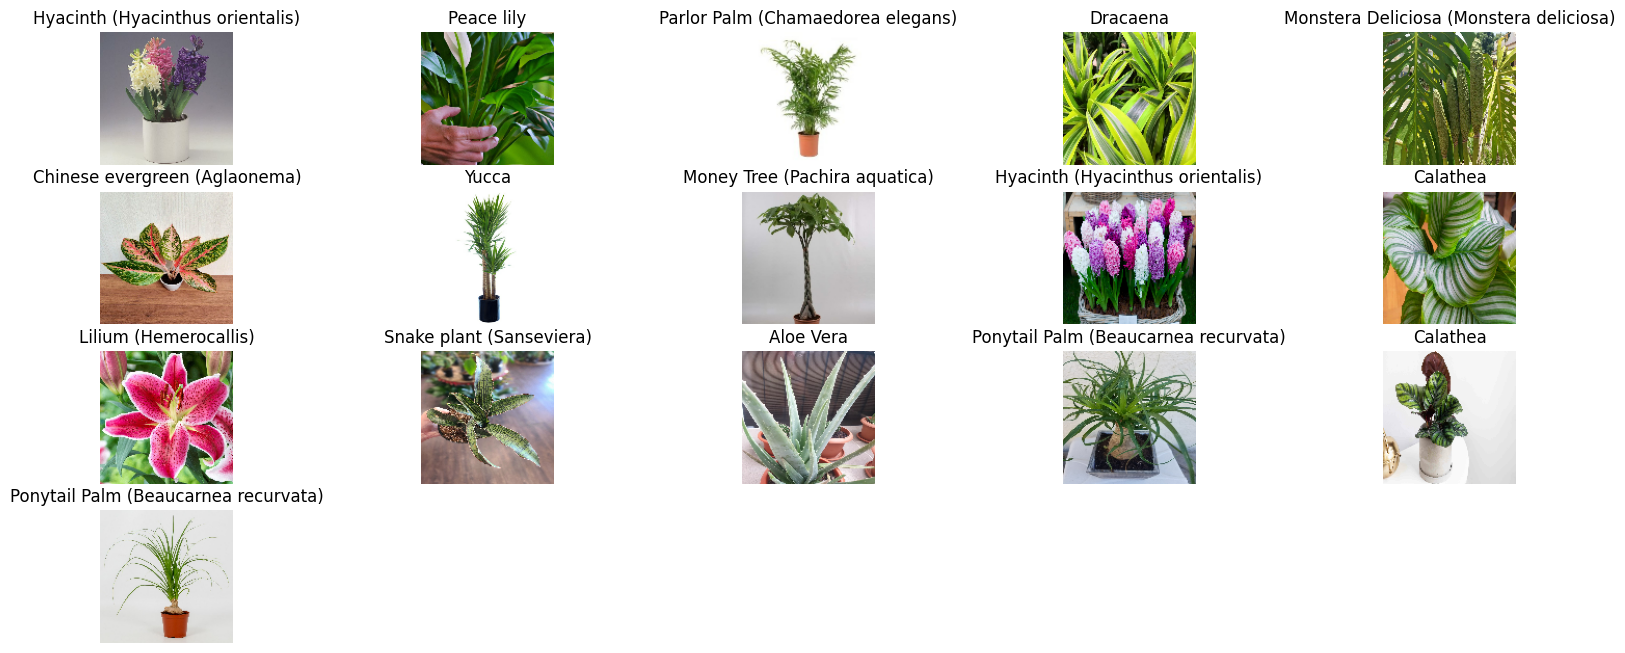

In [69]:
plt.figure(figsize=(20,10))

for images, labels in train_ds.take(1):
    batch_size = images.shape[0]  # tamaño real del batch
    for i in range(min(25, batch_size)):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(classes_names[labels[i]])
        plt.axis('off')

### Aumento de datos

In [70]:
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomContrast

data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.2),
    RandomZoom(0.2),
    RandomContrast(0.2),
])

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

Norm_layer=tf.keras.layers.Rescaling(1/255)
train_ds=train_ds.map(lambda x , y :(Norm_layer(x),y))
test_ds=test_ds.map(lambda x , y :(Norm_layer(x),y))

## Crear el modelo
Este modelo es una CNN (Convolutional Neural Network) construida con Sequential, que es una forma de apilar capas en orden secuencial en Keras.

In [71]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input

# Definicion del modelo
model = Sequential()

# Capas de extraccion de caracteristicas
model.add(Input(shape=(128, 128, 3)))
model.add(Conv2D(32, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))

model.add(Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))

model.add(Conv2D(128, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))

model.add(Conv2D(256, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(256, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))

# Flatten
model.add(Flatten())


model.add(Dropout(0.30))
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())

model.add(Dropout(0.30))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())

model.add(Dense(len(classes_names), activation='softmax'))

In [72]:
model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_40 (Conv2D)              │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_50          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_51          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_52          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_53          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_54          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_45 (Conv2D)              │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_55          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_46 (Conv2D)              │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_56          │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_47 (Conv2D)              │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_57          │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 16384)          │             

 Total params: 5,411,151 (20.64 MB)

 Trainable params: 5,408,463 (20.63 MB)

 Non-trainable params: 2,688 (10.50 KB)

## Entrenamiento del modelo

In [73]:
for images, labels in train_ds.take(1):
    print(images.shape)

(16, 128, 128, 3)


2025-05-30 15:42:44.537591: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [74]:
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import Adam

# Use Adam optimizer with the new learning rate schedule
optimizer = 'Adam'

# Compile the model with the new optimizer
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [75]:
early_stopping=EarlyStopping(monitor='val_accuracy',patience=5,restore_best_weights=True)

In [76]:
history=model.fit(train_ds,validation_data=test_ds,epochs=50,callbacks=[early_stopping])

Epoch 1/50
103/546 ━━━━━━━━━━━━━━━━━━━━ 1:54 258ms/step - accuracy: 0.0457 - loss: 4.1604

2025-05-30 15:43:25.780022: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


220/546 ━━━━━━━━━━━━━━━━━━━━ 1:23 255ms/step - accuracy: 0.0609 - loss: 3.9623

2025-05-30 15:43:55.145185: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


248/546 ━━━━━━━━━━━━━━━━━━━━ 1:15 254ms/step - accuracy: 0.0639 - loss: 3.9297

2025-05-30 15:44:02.272871: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


273/546 ━━━━━━━━━━━━━━━━━━━━ 1:09 253ms/step - accuracy: 0.0664 - loss: 3.9027

2025-05-30 15:44:08.377376: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: eXIf: duplicate


328/546 ━━━━━━━━━━━━━━━━━━━━ 56s 257ms/step - accuracy: 0.0711 - loss: 3.8515

2025-05-30 15:44:23.646836: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: eXIf: duplicate


330/546 ━━━━━━━━━━━━━━━━━━━━ 55s 258ms/step - accuracy: 0.0713 - loss: 3.8498

2025-05-30 15:44:24.213070: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


342/546 ━━━━━━━━━━━━━━━━━━━━ 53s 260ms/step - accuracy: 0.0723 - loss: 3.8397

2025-05-30 15:44:28.247670: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


395/546 ━━━━━━━━━━━━━━━━━━━━ 41s 273ms/step - accuracy: 0.0761 - loss: 3.8007

2025-05-30 15:44:47.117450: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


419/546 ━━━━━━━━━━━━━━━━━━━━ 35s 277ms/step - accuracy: 0.0777 - loss: 3.7850

2025-05-30 15:44:55.118672: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - accuracy: 0.0850 - loss: 3.7154

2025-05-30 15:45:50.274309: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-05-30 15:45:52.411309: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


546/546 ━━━━━━━━━━━━━━━━━━━━ 186s 326ms/step - accuracy: 0.0850 - loss: 3.7149 - val_accuracy: 0.1051 - val_loss: 3.6579
Epoch 2/50
105/546 ━━━━━━━━━━━━━━━━━━━━ 1:56 264ms/step - accuracy: 0.1713 - loss: 3.1671

2025-05-30 15:46:26.126026: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


218/546 ━━━━━━━━━━━━━━━━━━━━ 1:31 279ms/step - accuracy: 0.1664 - loss: 3.1721

2025-05-30 15:46:59.132526: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


238/546 ━━━━━━━━━━━━━━━━━━━━ 1:26 281ms/step - accuracy: 0.1666 - loss: 3.1711

2025-05-30 15:47:05.231775: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


261/546 ━━━━━━━━━━━━━━━━━━━━ 1:20 281ms/step - accuracy: 0.1670 - loss: 3.1687

2025-05-30 15:47:11.711269: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: eXIf: duplicate


327/546 ━━━━━━━━━━━━━━━━━━━━ 1:01 281ms/step - accuracy: 0.1684 - loss: 3.1591

2025-05-30 15:47:30.318169: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


332/546 ━━━━━━━━━━━━━━━━━━━━ 1:00 281ms/step - accuracy: 0.1686 - loss: 3.1583

2025-05-30 15:47:31.856398: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: eXIf: duplicate


352/546 ━━━━━━━━━━━━━━━━━━━━ 55s 284ms/step - accuracy: 0.1691 - loss: 3.1552

2025-05-30 15:47:38.531407: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


405/546 ━━━━━━━━━━━━━━━━━━━━ 40s 286ms/step - accuracy: 0.1705 - loss: 3.1484

2025-05-30 15:47:54.415994: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


428/546 ━━━━━━━━━━━━━━━━━━━━ 33s 287ms/step - accuracy: 0.1710 - loss: 3.1457

2025-05-30 15:48:01.330166: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.1731 - loss: 3.1322

2025-05-30 15:48:50.783781: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-05-30 15:48:53.900937: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


546/546 ━━━━━━━━━━━━━━━━━━━━ 181s 330ms/step - accuracy: 0.1731 - loss: 3.1320 - val_accuracy: 0.1918 - val_loss: 3.2656
Epoch 3/50
 97/546 ━━━━━━━━━━━━━━━━━━━━ 1:59 267ms/step - accuracy: 0.2308 - loss: 2.8574

2025-05-30 15:49:24.954255: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


234/546 ━━━━━━━━━━━━━━━━━━━━ 1:24 271ms/step - accuracy: 0.2232 - loss: 2.8947

2025-05-30 15:50:02.436578: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


258/546 ━━━━━━━━━━━━━━━━━━━━ 1:17 271ms/step - accuracy: 0.2228 - loss: 2.8971

2025-05-30 15:50:08.881298: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


261/546 ━━━━━━━━━━━━━━━━━━━━ 1:17 271ms/step - accuracy: 0.2227 - loss: 2.8973

2025-05-30 15:50:09.708705: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: eXIf: duplicate


334/546 ━━━━━━━━━━━━━━━━━━━━ 58s 275ms/step - accuracy: 0.2225 - loss: 2.8974

2025-05-30 15:50:30.883682: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


335/546 ━━━━━━━━━━━━━━━━━━━━ 58s 275ms/step - accuracy: 0.2225 - loss: 2.8974

2025-05-30 15:50:31.292970: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: eXIf: duplicate


355/546 ━━━━━━━━━━━━━━━━━━━━ 52s 276ms/step - accuracy: 0.2226 - loss: 2.8969

2025-05-30 15:50:37.201334: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


389/546 ━━━━━━━━━━━━━━━━━━━━ 43s 276ms/step - accuracy: 0.2228 - loss: 2.8959

2025-05-30 15:50:46.607559: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


423/546 ━━━━━━━━━━━━━━━━━━━━ 34s 277ms/step - accuracy: 0.2230 - loss: 2.8950

2025-05-30 15:50:56.423174: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - accuracy: 0.2239 - loss: 2.8889

2025-05-30 15:51:48.955397: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-05-30 15:51:51.616493: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


546/546 ━━━━━━━━━━━━━━━━━━━━ 178s 325ms/step - accuracy: 0.2239 - loss: 2.8889 - val_accuracy: 0.2184 - val_loss: 3.1729
Epoch 4/50
108/546 ━━━━━━━━━━━━━━━━━━━━ 1:58 271ms/step - accuracy: 0.2886 - loss: 2.7116

2025-05-30 15:52:26.728078: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


215/546 ━━━━━━━━━━━━━━━━━━━━ 1:33 282ms/step - accuracy: 0.2847 - loss: 2.7004

2025-05-30 15:52:58.121591: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


252/546 ━━━━━━━━━━━━━━━━━━━━ 1:23 285ms/step - accuracy: 0.2834 - loss: 2.7006

2025-05-30 15:53:09.267530: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


262/546 ━━━━━━━━━━━━━━━━━━━━ 1:20 285ms/step - accuracy: 0.2831 - loss: 2.7004

2025-05-30 15:53:12.083320: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: eXIf: duplicate


327/546 ━━━━━━━━━━━━━━━━━━━━ 1:02 285ms/step - accuracy: 0.2813 - loss: 2.6972

2025-05-30 15:53:30.558259: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


336/546 ━━━━━━━━━━━━━━━━━━━━ 59s 284ms/step - accuracy: 0.2812 - loss: 2.6966

2025-05-30 15:53:32.997837: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: eXIf: duplicate


365/546 ━━━━━━━━━━━━━━━━━━━━ 52s 290ms/step - accuracy: 0.2810 - loss: 2.6946

2025-05-30 15:53:43.236346: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


391/546 ━━━━━━━━━━━━━━━━━━━━ 45s 291ms/step - accuracy: 0.2808 - loss: 2.6935

2025-05-30 15:53:51.102154: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


430/546 ━━━━━━━━━━━━━━━━━━━━ 33s 291ms/step - accuracy: 0.2804 - loss: 2.6923

2025-05-30 15:54:02.495840: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - accuracy: 0.2801 - loss: 2.6880

2025-05-30 15:54:55.887775: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-05-30 15:54:57.342903: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


546/546 ━━━━━━━━━━━━━━━━━━━━ 185s 336ms/step - accuracy: 0.2801 - loss: 2.6880 - val_accuracy: 0.2855 - val_loss: 2.7196
Epoch 5/50
101/546 ━━━━━━━━━━━━━━━━━━━━ 2:02 276ms/step - accuracy: 0.3096 - loss: 2.5285

2025-05-30 15:55:29.693573: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


224/546 ━━━━━━━━━━━━━━━━━━━━ 1:29 279ms/step - accuracy: 0.3058 - loss: 2.5453

2025-05-30 15:56:04.390127: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


241/546 ━━━━━━━━━━━━━━━━━━━━ 1:25 280ms/step - accuracy: 0.3057 - loss: 2.5464

2025-05-30 15:56:09.236858: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


260/546 ━━━━━━━━━━━━━━━━━━━━ 1:20 280ms/step - accuracy: 0.3057 - loss: 2.5467

2025-05-30 15:56:14.665875: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: eXIf: duplicate


328/546 ━━━━━━━━━━━━━━━━━━━━ 1:00 280ms/step - accuracy: 0.3062 - loss: 2.5438

2025-05-30 15:56:33.503005: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: eXIf: duplicate


329/546 ━━━━━━━━━━━━━━━━━━━━ 1:00 280ms/step - accuracy: 0.3062 - loss: 2.5438

2025-05-30 15:56:33.778569: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


351/546 ━━━━━━━━━━━━━━━━━━━━ 54s 280ms/step - accuracy: 0.3065 - loss: 2.5422

2025-05-30 15:56:40.114513: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


398/546 ━━━━━━━━━━━━━━━━━━━━ 41s 280ms/step - accuracy: 0.3071 - loss: 2.5398

2025-05-30 15:56:53.214044: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


418/546 ━━━━━━━━━━━━━━━━━━━━ 35s 280ms/step - accuracy: 0.3072 - loss: 2.5392

2025-05-30 15:56:59.001925: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - accuracy: 0.3082 - loss: 2.5357

2025-05-30 15:57:54.458754: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-05-30 15:57:56.673731: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


546/546 ━━━━━━━━━━━━━━━━━━━━ 180s 329ms/step - accuracy: 0.3082 - loss: 2.5357 - val_accuracy: 0.2473 - val_loss: 3.0166
Epoch 6/50
103/546 ━━━━━━━━━━━━━━━━━━━━ 2:09 292ms/step - accuracy: 0.3091 - loss: 2.4711

2025-05-30 15:58:32.168351: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


214/546 ━━━━━━━━━━━━━━━━━━━━ 1:36 291ms/step - accuracy: 0.3175 - loss: 2.4410

2025-05-30 15:59:04.355195: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


237/546 ━━━━━━━━━━━━━━━━━━━━ 1:31 296ms/step - accuracy: 0.3182 - loss: 2.4390

2025-05-30 15:59:12.227913: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


294/546 ━━━━━━━━━━━━━━━━━━━━ 1:14 296ms/step - accuracy: 0.3199 - loss: 2.4325

2025-05-30 15:59:29.249684: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: eXIf: duplicate


325/546 ━━━━━━━━━━━━━━━━━━━━ 1:05 296ms/step - accuracy: 0.3206 - loss: 2.4296

2025-05-30 15:59:38.288251: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


331/546 ━━━━━━━━━━━━━━━━━━━━ 1:03 296ms/step - accuracy: 0.3208 - loss: 2.4291

2025-05-30 15:59:40.187618: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: eXIf: duplicate


351/546 ━━━━━━━━━━━━━━━━━━━━ 57s 295ms/step - accuracy: 0.3213 - loss: 2.4275

2025-05-30 15:59:45.861789: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


405/546 ━━━━━━━━━━━━━━━━━━━━ 41s 293ms/step - accuracy: 0.3227 - loss: 2.4244

2025-05-30 16:00:00.732731: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


416/546 ━━━━━━━━━━━━━━━━━━━━ 38s 293ms/step - accuracy: 0.3229 - loss: 2.4238

2025-05-30 16:00:04.157562: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.3263 - loss: 2.4169

2025-05-30 16:00:59.947514: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-05-30 16:01:04.815166: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


546/546 ━━━━━━━━━━━━━━━━━━━━ 186s 339ms/step - accuracy: 0.3263 - loss: 2.4168 - val_accuracy: 0.2486 - val_loss: 3.3338
Epoch 7/50
101/546 ━━━━━━━━━━━━━━━━━━━━ 2:03 278ms/step - accuracy: 0.3453 - loss: 2.3173

2025-05-30 16:01:35.856050: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


218/546 ━━━━━━━━━━━━━━━━━━━━ 1:31 278ms/step - accuracy: 0.3509 - loss: 2.3125

2025-05-30 16:02:08.289638: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


236/546 ━━━━━━━━━━━━━━━━━━━━ 1:26 278ms/step - accuracy: 0.3514 - loss: 2.3126

2025-05-30 16:02:13.421682: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


282/546 ━━━━━━━━━━━━━━━━━━━━ 1:13 277ms/step - accuracy: 0.3525 - loss: 2.3110

2025-05-30 16:02:25.855451: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: eXIf: duplicate


335/546 ━━━━━━━━━━━━━━━━━━━━ 59s 282ms/step - accuracy: 0.3535 - loss: 2.3079

2025-05-30 16:02:42.165381: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


340/546 ━━━━━━━━━━━━━━━━━━━━ 58s 282ms/step - accuracy: 0.3536 - loss: 2.3076

2025-05-30 16:02:43.560881: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: eXIf: duplicate


363/546 ━━━━━━━━━━━━━━━━━━━━ 51s 281ms/step - accuracy: 0.3540 - loss: 2.3060

2025-05-30 16:02:49.889165: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


391/546 ━━━━━━━━━━━━━━━━━━━━ 43s 281ms/step - accuracy: 0.3544 - loss: 2.3046

2025-05-30 16:02:57.651991: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


419/546 ━━━━━━━━━━━━━━━━━━━━ 35s 282ms/step - accuracy: 0.3549 - loss: 2.3035

2025-05-30 16:03:05.755071: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.3567 - loss: 2.2978

2025-05-30 16:03:59.451035: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-05-30 16:04:01.744043: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


546/546 ━━━━━━━━━━━━━━━━━━━━ 180s 329ms/step - accuracy: 0.3567 - loss: 2.2977 - val_accuracy: 0.3272 - val_loss: 2.6167
Epoch 8/50
106/546 ━━━━━━━━━━━━━━━━━━━━ 2:03 280ms/step - accuracy: 0.3650 - loss: 2.2572

2025-05-30 16:04:38.084447: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


226/546 ━━━━━━━━━━━━━━━━━━━━ 1:33 293ms/step - accuracy: 0.3737 - loss: 2.2326

2025-05-30 16:05:14.602682: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


255/546 ━━━━━━━━━━━━━━━━━━━━ 1:25 293ms/step - accuracy: 0.3743 - loss: 2.2307

2025-05-30 16:05:23.104377: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


264/546 ━━━━━━━━━━━━━━━━━━━━ 1:22 293ms/step - accuracy: 0.3745 - loss: 2.2301

2025-05-30 16:05:25.772368: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: eXIf: duplicate


335/546 ━━━━━━━━━━━━━━━━━━━━ 1:02 294ms/step - accuracy: 0.3763 - loss: 2.2233

2025-05-30 16:05:46.971042: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


338/546 ━━━━━━━━━━━━━━━━━━━━ 1:01 294ms/step - accuracy: 0.3764 - loss: 2.2230

2025-05-30 16:05:47.793273: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: eXIf: duplicate


351/546 ━━━━━━━━━━━━━━━━━━━━ 57s 293ms/step - accuracy: 0.3767 - loss: 2.2215

2025-05-30 16:05:51.201334: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


393/546 ━━━━━━━━━━━━━━━━━━━━ 45s 294ms/step - accuracy: 0.3774 - loss: 2.2185

2025-05-30 16:06:03.985559: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


430/546 ━━━━━━━━━━━━━━━━━━━━ 34s 294ms/step - accuracy: 0.3779 - loss: 2.2168

2025-05-30 16:06:14.738311: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.3797 - loss: 2.2118

2025-05-30 16:07:08.336359: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-05-30 16:07:09.781636: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


546/546 ━━━━━━━━━━━━━━━━━━━━ 188s 342ms/step - accuracy: 0.3797 - loss: 2.2118 - val_accuracy: 0.3654 - val_loss: 2.4794
Epoch 9/50
110/546 ━━━━━━━━━━━━━━━━━━━━ 2:13 306ms/step - accuracy: 0.4088 - loss: 2.1011

2025-05-30 16:07:49.637348: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


225/546 ━━━━━━━━━━━━━━━━━━━━ 1:34 294ms/step - accuracy: 0.4107 - loss: 2.1028

2025-05-30 16:08:22.092285: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


238/546 ━━━━━━━━━━━━━━━━━━━━ 1:30 295ms/step - accuracy: 0.4108 - loss: 2.1033

2025-05-30 16:08:26.292595: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


261/546 ━━━━━━━━━━━━━━━━━━━━ 1:26 303ms/step - accuracy: 0.4110 - loss: 2.1035

2025-05-30 16:08:35.086838: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: eXIf: duplicate


325/546 ━━━━━━━━━━━━━━━━━━━━ 1:08 310ms/step - accuracy: 0.4118 - loss: 2.1005

2025-05-30 16:08:56.796923: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


338/546 ━━━━━━━━━━━━━━━━━━━━ 1:04 311ms/step - accuracy: 0.4120 - loss: 2.0996

2025-05-30 16:09:01.344775: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: eXIf: duplicate


350/546 ━━━━━━━━━━━━━━━━━━━━ 1:01 312ms/step - accuracy: 0.4122 - loss: 2.0987

2025-05-30 16:09:05.047165: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


397/546 ━━━━━━━━━━━━━━━━━━━━ 46s 312ms/step - accuracy: 0.4125 - loss: 2.0969

2025-05-30 16:09:19.793035: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


425/546 ━━━━━━━━━━━━━━━━━━━━ 37s 313ms/step - accuracy: 0.4127 - loss: 2.0962

2025-05-30 16:09:28.874958: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - accuracy: 0.4128 - loss: 2.0943

2025-05-30 16:10:25.167775: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-05-30 16:10:30.055538: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


546/546 ━━━━━━━━━━━━━━━━━━━━ 198s 360ms/step - accuracy: 0.4128 - loss: 2.0943 - val_accuracy: 0.2976 - val_loss: 3.0215
Epoch 10/50
109/546 ━━━━━━━━━━━━━━━━━━━━ 2:31 346ms/step - accuracy: 0.4274 - loss: 1.9865

2025-05-30 16:11:11.291599: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


214/546 ━━━━━━━━━━━━━━━━━━━━ 1:48 326ms/step - accuracy: 0.4299 - loss: 2.0016

2025-05-30 16:11:43.256589: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


239/546 ━━━━━━━━━━━━━━━━━━━━ 1:39 324ms/step - accuracy: 0.4303 - loss: 2.0033

2025-05-30 16:11:50.929338: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


261/546 ━━━━━━━━━━━━━━━━━━━━ 1:31 320ms/step - accuracy: 0.4308 - loss: 2.0044

2025-05-30 16:11:57.087653: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: eXIf: duplicate


324/546 ━━━━━━━━━━━━━━━━━━━━ 1:10 317ms/step - accuracy: 0.4322 - loss: 2.0032

2025-05-30 16:12:16.252994: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


329/546 ━━━━━━━━━━━━━━━━━━━━ 1:08 316ms/step - accuracy: 0.4323 - loss: 2.0031

2025-05-30 16:12:17.695042: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: eXIf: duplicate


347/546 ━━━━━━━━━━━━━━━━━━━━ 1:02 315ms/step - accuracy: 0.4327 - loss: 2.0026

2025-05-30 16:12:23.062108: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


390/546 ━━━━━━━━━━━━━━━━━━━━ 48s 312ms/step - accuracy: 0.4334 - loss: 2.0022

2025-05-30 16:12:35.422931: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


426/546 ━━━━━━━━━━━━━━━━━━━━ 37s 310ms/step - accuracy: 0.4338 - loss: 2.0023

2025-05-30 16:12:45.738710: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - accuracy: 0.4347 - loss: 2.0019

2025-05-30 16:13:39.209436: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-05-30 16:13:42.035928: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


546/546 ━━━━━━━━━━━━━━━━━━━━ 194s 353ms/step - accuracy: 0.4347 - loss: 2.0019 - val_accuracy: 0.3471 - val_loss: 2.6667
Epoch 11/50
 99/546 ━━━━━━━━━━━━━━━━━━━━ 2:07 286ms/step - accuracy: 0.4551 - loss: 1.9330

2025-05-30 16:14:15.392964: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


213/546 ━━━━━━━━━━━━━━━━━━━━ 1:36 291ms/step - accuracy: 0.4534 - loss: 1.9463

2025-05-30 16:14:48.953213: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


248/546 ━━━━━━━━━━━━━━━━━━━━ 1:26 289ms/step - accuracy: 0.4527 - loss: 1.9492

2025-05-30 16:14:58.792442: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


259/546 ━━━━━━━━━━━━━━━━━━━━ 1:23 290ms/step - accuracy: 0.4524 - loss: 1.9501

2025-05-30 16:15:02.271174: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: eXIf: duplicate


333/546 ━━━━━━━━━━━━━━━━━━━━ 1:01 291ms/step - accuracy: 0.4521 - loss: 1.9505

2025-05-30 16:15:23.855956: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


336/546 ━━━━━━━━━━━━━━━━━━━━ 1:01 291ms/step - accuracy: 0.4521 - loss: 1.9504

2025-05-30 16:15:24.721538: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: eXIf: duplicate


342/546 ━━━━━━━━━━━━━━━━━━━━ 59s 292ms/step - accuracy: 0.4521 - loss: 1.9502

2025-05-30 16:15:26.791206: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


389/546 ━━━━━━━━━━━━━━━━━━━━ 45s 290ms/step - accuracy: 0.4520 - loss: 1.9490

2025-05-30 16:15:39.785848: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


420/546 ━━━━━━━━━━━━━━━━━━━━ 36s 289ms/step - accuracy: 0.4520 - loss: 1.9484

2025-05-30 16:15:48.503750: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - accuracy: 0.4522 - loss: 1.9455

2025-05-30 16:16:42.943602: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-05-30 16:16:44.339188: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


546/546 ━━━━━━━━━━━━━━━━━━━━ 183s 334ms/step - accuracy: 0.4523 - loss: 1.9455 - val_accuracy: 0.4370 - val_loss: 2.1003
Epoch 12/50
112/546 ━━━━━━━━━━━━━━━━━━━━ 2:06 291ms/step - accuracy: 0.4538 - loss: 1.8730

2025-05-30 16:17:22.802475: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


218/546 ━━━━━━━━━━━━━━━━━━━━ 1:37 296ms/step - accuracy: 0.4547 - loss: 1.8893

2025-05-30 16:17:54.820608: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


240/546 ━━━━━━━━━━━━━━━━━━━━ 1:30 296ms/step - accuracy: 0.4551 - loss: 1.8906

2025-05-30 16:18:01.384012: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


267/546 ━━━━━━━━━━━━━━━━━━━━ 1:22 296ms/step - accuracy: 0.4558 - loss: 1.8909

2025-05-30 16:18:09.366727: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: eXIf: duplicate


333/546 ━━━━━━━━━━━━━━━━━━━━ 1:03 300ms/step - accuracy: 0.4585 - loss: 1.8866

2025-05-30 16:18:30.269842: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


335/546 ━━━━━━━━━━━━━━━━━━━━ 1:03 302ms/step - accuracy: 0.4585 - loss: 1.8864

2025-05-30 16:18:31.285467: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: eXIf: duplicate


348/546 ━━━━━━━━━━━━━━━━━━━━ 1:00 306ms/step - accuracy: 0.4591 - loss: 1.8853

2025-05-30 16:18:36.871413: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


398/546 ━━━━━━━━━━━━━━━━━━━━ 46s 312ms/step - accuracy: 0.4606 - loss: 1.8830

2025-05-30 16:18:54.520280: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


417/546 ━━━━━━━━━━━━━━━━━━━━ 41s 325ms/step - accuracy: 0.4609 - loss: 1.8828

2025-05-30 16:19:05.847651: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - accuracy: 0.4632 - loss: 1.8801

2025-05-30 16:20:14.096997: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-05-30 16:20:16.705946: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


546/546 ━━━━━━━━━━━━━━━━━━━━ 213s 388ms/step - accuracy: 0.4632 - loss: 1.8801 - val_accuracy: 0.4256 - val_loss: 2.2127
Epoch 13/50
105/546 ━━━━━━━━━━━━━━━━━━━━ 2:14 305ms/step - accuracy: 0.4629 - loss: 1.8381

2025-05-30 16:20:54.736055: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


222/546 ━━━━━━━━━━━━━━━━━━━━ 1:36 297ms/step - accuracy: 0.4673 - loss: 1.8351

2025-05-30 16:21:28.590574: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


244/546 ━━━━━━━━━━━━━━━━━━━━ 1:29 297ms/step - accuracy: 0.4680 - loss: 1.8345

2025-05-30 16:21:35.056818: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


264/546 ━━━━━━━━━━━━━━━━━━━━ 1:23 295ms/step - accuracy: 0.4687 - loss: 1.8335

2025-05-30 16:21:40.597324: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: eXIf: duplicate


326/546 ━━━━━━━━━━━━━━━━━━━━ 1:04 292ms/step - accuracy: 0.4710 - loss: 1.8276

2025-05-30 16:21:57.875672: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


330/546 ━━━━━━━━━━━━━━━━━━━━ 1:03 292ms/step - accuracy: 0.4711 - loss: 1.8271

2025-05-30 16:21:59.138198: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: eXIf: duplicate


350/546 ━━━━━━━━━━━━━━━━━━━━ 57s 295ms/step - accuracy: 0.4719 - loss: 1.8249

2025-05-30 16:22:05.836371: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


391/546 ━━━━━━━━━━━━━━━━━━━━ 45s 294ms/step - accuracy: 0.4734 - loss: 1.8215

2025-05-30 16:22:17.553993: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


424/546 ━━━━━━━━━━━━━━━━━━━━ 36s 297ms/step - accuracy: 0.4743 - loss: 1.8193

2025-05-30 16:22:28.616503: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.4771 - loss: 1.8133

2025-05-30 16:23:23.543394: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-05-30 16:23:24.867102: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


546/546 ━━━━━━━━━━━━━━━━━━━━ 187s 341ms/step - accuracy: 0.4771 - loss: 1.8132 - val_accuracy: 0.4952 - val_loss: 1.8278
Epoch 14/50
101/546 ━━━━━━━━━━━━━━━━━━━━ 2:01 272ms/step - accuracy: 0.4757 - loss: 1.7345

2025-05-30 16:23:57.277966: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


219/546 ━━━━━━━━━━━━━━━━━━━━ 1:38 302ms/step - accuracy: 0.4888 - loss: 1.7412

2025-05-30 16:24:35.972770: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


247/546 ━━━━━━━━━━━━━━━━━━━━ 1:30 302ms/step - accuracy: 0.4904 - loss: 1.7437

2025-05-30 16:24:44.460858: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


273/546 ━━━━━━━━━━━━━━━━━━━━ 1:22 301ms/step - accuracy: 0.4916 - loss: 1.7449

2025-05-30 16:24:51.983920: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: eXIf: duplicate


324/546 ━━━━━━━━━━━━━━━━━━━━ 1:06 299ms/step - accuracy: 0.4941 - loss: 1.7440

2025-05-30 16:25:06.584811: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


331/546 ━━━━━━━━━━━━━━━━━━━━ 1:04 299ms/step - accuracy: 0.4944 - loss: 1.7436

2025-05-30 16:25:08.630595: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: eXIf: duplicate


355/546 ━━━━━━━━━━━━━━━━━━━━ 56s 298ms/step - accuracy: 0.4957 - loss: 1.7421

2025-05-30 16:25:15.451741: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


392/546 ━━━━━━━━━━━━━━━━━━━━ 46s 300ms/step - accuracy: 0.4974 - loss: 1.7406

2025-05-30 16:25:27.157253: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


425/546 ━━━━━━━━━━━━━━━━━━━━ 36s 300ms/step - accuracy: 0.4984 - loss: 1.7397

2025-05-30 16:25:37.077751: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.5012 - loss: 1.7374

2025-05-30 16:26:32.197383: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-05-30 16:26:33.598495: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


546/546 ━━━━━━━━━━━━━━━━━━━━ 190s 346ms/step - accuracy: 0.5013 - loss: 1.7374 - val_accuracy: 0.4636 - val_loss: 1.9796
Epoch 15/50
 98/546 ━━━━━━━━━━━━━━━━━━━━ 2:17 308ms/step - accuracy: 0.5248 - loss: 1.7355

2025-05-30 16:27:10.216265: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


213/546 ━━━━━━━━━━━━━━━━━━━━ 1:41 305ms/step - accuracy: 0.5197 - loss: 1.7132

2025-05-30 16:27:45.118831: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


239/546 ━━━━━━━━━━━━━━━━━━━━ 1:33 305ms/step - accuracy: 0.5188 - loss: 1.7115

2025-05-30 16:27:52.884650: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


263/546 ━━━━━━━━━━━━━━━━━━━━ 1:25 303ms/step - accuracy: 0.5184 - loss: 1.7090

2025-05-30 16:27:59.758341: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: eXIf: duplicate


334/546 ━━━━━━━━━━━━━━━━━━━━ 1:03 299ms/step - accuracy: 0.5186 - loss: 1.6988

2025-05-30 16:28:19.853995: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


343/546 ━━━━━━━━━━━━━━━━━━━━ 1:00 299ms/step - accuracy: 0.5187 - loss: 1.6975

2025-05-30 16:28:22.468899: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


345/546 ━━━━━━━━━━━━━━━━━━━━ 1:00 299ms/step - accuracy: 0.5187 - loss: 1.6973

2025-05-30 16:28:23.162821: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: eXIf: duplicate


394/546 ━━━━━━━━━━━━━━━━━━━━ 45s 297ms/step - accuracy: 0.5187 - loss: 1.6931

2025-05-30 16:28:37.055718: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


425/546 ━━━━━━━━━━━━━━━━━━━━ 35s 296ms/step - accuracy: 0.5185 - loss: 1.6915

2025-05-30 16:28:45.926452: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.5186 - loss: 1.6858

2025-05-30 16:29:41.462761: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-05-30 16:29:42.370642: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


546/546 ━━━━━━━━━━━━━━━━━━━━ 189s 343ms/step - accuracy: 0.5186 - loss: 1.6858 - val_accuracy: 0.4906 - val_loss: 1.8505
Epoch 16/50
101/546 ━━━━━━━━━━━━━━━━━━━━ 2:11 296ms/step - accuracy: 0.5215 - loss: 1.6952

2025-05-30 16:30:18.945430: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


218/546 ━━━━━━━━━━━━━━━━━━━━ 1:34 289ms/step - accuracy: 0.5270 - loss: 1.6611

2025-05-30 16:30:52.022781: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


254/546 ━━━━━━━━━━━━━━━━━━━━ 1:25 293ms/step - accuracy: 0.5280 - loss: 1.6540

2025-05-30 16:31:03.851941: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


261/546 ━━━━━━━━━━━━━━━━━━━━ 1:24 295ms/step - accuracy: 0.5283 - loss: 1.6526

2025-05-30 16:31:06.321789: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: eXIf: duplicate


333/546 ━━━━━━━━━━━━━━━━━━━━ 1:02 295ms/step - accuracy: 0.5302 - loss: 1.6400

2025-05-30 16:31:27.367957: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


343/546 ━━━━━━━━━━━━━━━━━━━━ 59s 296ms/step - accuracy: 0.5303 - loss: 1.6387 

2025-05-30 16:31:30.673542: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: eXIf: duplicate


360/546 ━━━━━━━━━━━━━━━━━━━━ 55s 296ms/step - accuracy: 0.5306 - loss: 1.6369

2025-05-30 16:31:35.723304: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


395/546 ━━━━━━━━━━━━━━━━━━━━ 44s 296ms/step - accuracy: 0.5310 - loss: 1.6339

2025-05-30 16:31:46.386939: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


441/546 ━━━━━━━━━━━━━━━━━━━━ 31s 295ms/step - accuracy: 0.5314 - loss: 1.6315

2025-05-30 16:31:59.559187: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.5323 - loss: 1.6258

2025-05-30 16:32:48.497553: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-05-30 16:32:51.877450: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


546/546 ━━━━━━━━━━━━━━━━━━━━ 189s 343ms/step - accuracy: 0.5323 - loss: 1.6258 - val_accuracy: 0.4737 - val_loss: 2.0565
Epoch 17/50
 98/546 ━━━━━━━━━━━━━━━━━━━━ 2:22 318ms/step - accuracy: 0.5431 - loss: 1.6301

2025-05-30 16:33:28.334847: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


223/546 ━━━━━━━━━━━━━━━━━━━━ 1:43 321ms/step - accuracy: 0.5396 - loss: 1.6252

2025-05-30 16:34:08.712880: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


250/546 ━━━━━━━━━━━━━━━━━━━━ 1:37 329ms/step - accuracy: 0.5393 - loss: 1.6231

2025-05-30 16:34:19.496333: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


261/546 ━━━━━━━━━━━━━━━━━━━━ 1:34 333ms/step - accuracy: 0.5393 - loss: 1.6222

2025-05-30 16:34:24.088566: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: eXIf: duplicate


330/546 ━━━━━━━━━━━━━━━━━━━━ 1:12 334ms/step - accuracy: 0.5404 - loss: 1.6131

2025-05-30 16:34:47.354633: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


338/546 ━━━━━━━━━━━━━━━━━━━━ 1:09 333ms/step - accuracy: 0.5404 - loss: 1.6122

2025-05-30 16:34:49.712106: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: eXIf: duplicate


347/546 ━━━━━━━━━━━━━━━━━━━━ 1:06 332ms/step - accuracy: 0.5405 - loss: 1.6113

2025-05-30 16:34:52.248732: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


394/546 ━━━━━━━━━━━━━━━━━━━━ 49s 327ms/step - accuracy: 0.5409 - loss: 1.6074

2025-05-30 16:35:05.923695: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


419/546 ━━━━━━━━━━━━━━━━━━━━ 41s 325ms/step - accuracy: 0.5410 - loss: 1.6058

2025-05-30 16:35:13.304543: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - accuracy: 0.5420 - loss: 1.5979

2025-05-30 16:36:09.653709: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-05-30 16:36:15.283724: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


546/546 ━━━━━━━━━━━━━━━━━━━━ 201s 366ms/step - accuracy: 0.5420 - loss: 1.5978 - val_accuracy: 0.4831 - val_loss: 1.8918
Epoch 18/50
 99/546 ━━━━━━━━━━━━━━━━━━━━ 2:22 319ms/step - accuracy: 0.5647 - loss: 1.4802

2025-05-30 16:36:49.801106: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


216/546 ━━━━━━━━━━━━━━━━━━━━ 1:42 310ms/step - accuracy: 0.5634 - loss: 1.4998

2025-05-30 16:37:25.068145: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


238/546 ━━━━━━━━━━━━━━━━━━━━ 1:35 309ms/step - accuracy: 0.5634 - loss: 1.5015

2025-05-30 16:37:31.669444: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


264/546 ━━━━━━━━━━━━━━━━━━━━ 1:26 307ms/step - accuracy: 0.5636 - loss: 1.5024

2025-05-30 16:37:39.246364: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: eXIf: duplicate


335/546 ━━━━━━━━━━━━━━━━━━━━ 1:05 310ms/step - accuracy: 0.5648 - loss: 1.5011

2025-05-30 16:38:02.095893: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: eXIf: duplicate


357/546 ━━━━━━━━━━━━━━━━━━━━ 58s 309ms/step - accuracy: 0.5651 - loss: 1.5007

2025-05-30 16:38:08.504474: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-05-30 16:38:08.512536: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


391/546 ━━━━━━━━━━━━━━━━━━━━ 47s 309ms/step - accuracy: 0.5654 - loss: 1.5005

2025-05-30 16:38:18.921529: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


428/546 ━━━━━━━━━━━━━━━━━━━━ 36s 307ms/step - accuracy: 0.5653 - loss: 1.5010

2025-05-30 16:38:29.438584: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - accuracy: 0.5646 - loss: 1.5033

2025-05-30 16:39:25.166626: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-05-30 16:39:27.461368: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


546/546 ━━━━━━━━━━━━━━━━━━━━ 195s 356ms/step - accuracy: 0.5646 - loss: 1.5034 - val_accuracy: 0.5227 - val_loss: 1.6748
Epoch 19/50
105/546 ━━━━━━━━━━━━━━━━━━━━ 2:09 293ms/step - accuracy: 0.5599 - loss: 1.5323

2025-05-30 16:40:04.760084: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


220/546 ━━━━━━━━━━━━━━━━━━━━ 1:34 290ms/step - accuracy: 0.5636 - loss: 1.5100

2025-05-30 16:40:37.747587: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


240/546 ━━━━━━━━━━━━━━━━━━━━ 1:28 290ms/step - accuracy: 0.5639 - loss: 1.5086

2025-05-30 16:40:43.519023: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


275/546 ━━━━━━━━━━━━━━━━━━━━ 1:18 289ms/step - accuracy: 0.5647 - loss: 1.5055

2025-05-30 16:40:53.414913: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: eXIf: duplicate


326/546 ━━━━━━━━━━━━━━━━━━━━ 1:04 294ms/step - accuracy: 0.5659 - loss: 1.4999

2025-05-30 16:41:09.687964: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


335/546 ━━━━━━━━━━━━━━━━━━━━ 1:02 294ms/step - accuracy: 0.5661 - loss: 1.4991

2025-05-30 16:41:12.419976: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: eXIf: duplicate


345/546 ━━━━━━━━━━━━━━━━━━━━ 59s 294ms/step - accuracy: 0.5663 - loss: 1.4982

2025-05-30 16:41:15.365398: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


403/546 ━━━━━━━━━━━━━━━━━━━━ 42s 296ms/step - accuracy: 0.5669 - loss: 1.4954

2025-05-30 16:41:33.329261: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


417/546 ━━━━━━━━━━━━━━━━━━━━ 38s 297ms/step - accuracy: 0.5670 - loss: 1.4951

2025-05-30 16:41:37.788302: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.5675 - loss: 1.4933

2025-05-30 16:42:34.547670: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-05-30 16:42:37.121932: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


546/546 ━━━━━━━━━━━━━━━━━━━━ 189s 345ms/step - accuracy: 0.5675 - loss: 1.4933 - val_accuracy: 0.5362 - val_loss: 1.6601
Epoch 20/50
109/546 ━━━━━━━━━━━━━━━━━━━━ 2:01 277ms/step - accuracy: 0.5856 - loss: 1.4322

2025-05-30 16:43:13.091852: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


214/546 ━━━━━━━━━━━━━━━━━━━━ 1:35 287ms/step - accuracy: 0.5856 - loss: 1.4295

2025-05-30 16:43:44.295632: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


237/546 ━━━━━━━━━━━━━━━━━━━━ 1:28 287ms/step - accuracy: 0.5852 - loss: 1.4298

2025-05-30 16:43:50.933793: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


278/546 ━━━━━━━━━━━━━━━━━━━━ 1:16 287ms/step - accuracy: 0.5848 - loss: 1.4297

2025-05-30 16:44:02.607981: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: eXIf: duplicate


329/546 ━━━━━━━━━━━━━━━━━━━━ 1:02 289ms/step - accuracy: 0.5847 - loss: 1.4278

2025-05-30 16:44:17.943901: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-05-30 16:44:17.950109: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: eXIf: duplicate


362/546 ━━━━━━━━━━━━━━━━━━━━ 54s 298ms/step - accuracy: 0.5849 - loss: 1.4261

2025-05-30 16:44:30.776431: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


392/546 ━━━━━━━━━━━━━━━━━━━━ 46s 300ms/step - accuracy: 0.5850 - loss: 1.4253

2025-05-30 16:44:40.502081: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


421/546 ━━━━━━━━━━━━━━━━━━━━ 37s 300ms/step - accuracy: 0.5850 - loss: 1.4250

2025-05-30 16:44:49.009754: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 0.5853 - loss: 1.4239

2025-05-30 16:45:47.966052: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-05-30 16:45:50.496661: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


546/546 ━━━━━━━━━━━━━━━━━━━━ 193s 353ms/step - accuracy: 0.5853 - loss: 1.4239 - val_accuracy: 0.5405 - val_loss: 1.6400
Epoch 21/50
 99/546 ━━━━━━━━━━━━━━━━━━━━ 2:08 287ms/step - accuracy: 0.5763 - loss: 1.4477

2025-05-30 16:46:24.699794: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


217/546 ━━━━━━━━━━━━━━━━━━━━ 1:35 291ms/step - accuracy: 0.5839 - loss: 1.4289

2025-05-30 16:46:59.419116: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


258/546 ━━━━━━━━━━━━━━━━━━━━ 1:23 291ms/step - accuracy: 0.5854 - loss: 1.4257

2025-05-30 16:47:11.395203: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


262/546 ━━━━━━━━━━━━━━━━━━━━ 1:22 291ms/step - accuracy: 0.5855 - loss: 1.4253

2025-05-30 16:47:12.262914: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: eXIf: duplicate


329/546 ━━━━━━━━━━━━━━━━━━━━ 1:02 290ms/step - accuracy: 0.5873 - loss: 1.4189

2025-05-30 16:47:31.695263: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


345/546 ━━━━━━━━━━━━━━━━━━━━ 58s 290ms/step - accuracy: 0.5876 - loss: 1.4176

2025-05-30 16:47:36.424794: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: eXIf: duplicate


349/546 ━━━━━━━━━━━━━━━━━━━━ 57s 290ms/step - accuracy: 0.5877 - loss: 1.4173

2025-05-30 16:47:37.486309: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


398/546 ━━━━━━━━━━━━━━━━━━━━ 43s 292ms/step - accuracy: 0.5887 - loss: 1.4143

2025-05-30 16:47:52.448132: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


417/546 ━━━━━━━━━━━━━━━━━━━━ 37s 292ms/step - accuracy: 0.5889 - loss: 1.4136

2025-05-30 16:47:58.050983: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.5894 - loss: 1.4100

2025-05-30 16:48:51.977991: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-05-30 16:48:54.280751: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


546/546 ━━━━━━━━━━━━━━━━━━━━ 184s 335ms/step - accuracy: 0.5894 - loss: 1.4100 - val_accuracy: 0.5719 - val_loss: 1.5380
Epoch 22/50
101/546 ━━━━━━━━━━━━━━━━━━━━ 2:09 291ms/step - accuracy: 0.5861 - loss: 1.3758

2025-05-30 16:49:29.716465: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


214/546 ━━━━━━━━━━━━━━━━━━━━ 1:38 298ms/step - accuracy: 0.5942 - loss: 1.3666

2025-05-30 16:50:04.113092: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


248/546 ━━━━━━━━━━━━━━━━━━━━ 1:28 298ms/step - accuracy: 0.5960 - loss: 1.3639

2025-05-30 16:50:14.323822: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


264/546 ━━━━━━━━━━━━━━━━━━━━ 1:23 298ms/step - accuracy: 0.5968 - loss: 1.3625

2025-05-30 16:50:18.950072: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: eXIf: duplicate


328/546 ━━━━━━━━━━━━━━━━━━━━ 1:04 296ms/step - accuracy: 0.5991 - loss: 1.3570

2025-05-30 16:50:37.410164: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


336/546 ━━━━━━━━━━━━━━━━━━━━ 1:02 296ms/step - accuracy: 0.5994 - loss: 1.3564

2025-05-30 16:50:39.752708: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: eXIf: duplicate


357/546 ━━━━━━━━━━━━━━━━━━━━ 55s 295ms/step - accuracy: 0.6000 - loss: 1.3550

2025-05-30 16:50:45.828745: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


416/546 ━━━━━━━━━━━━━━━━━━━━ 38s 294ms/step - accuracy: 0.6015 - loss: 1.3525

2025-05-30 16:51:02.540951: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


429/546 ━━━━━━━━━━━━━━━━━━━━ 34s 294ms/step - accuracy: 0.6017 - loss: 1.3523

2025-05-30 16:51:06.622419: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.6031 - loss: 1.3499

2025-05-30 16:52:01.988317: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-05-30 16:52:05.824223: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


546/546 ━━━━━━━━━━━━━━━━━━━━ 191s 348ms/step - accuracy: 0.6031 - loss: 1.3499 - val_accuracy: 0.5902 - val_loss: 1.4100
Epoch 23/50
109/546 ━━━━━━━━━━━━━━━━━━━━ 2:14 309ms/step - accuracy: 0.6138 - loss: 1.3559

2025-05-30 16:52:45.018567: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


223/546 ━━━━━━━━━━━━━━━━━━━━ 1:35 296ms/step - accuracy: 0.6137 - loss: 1.3443

2025-05-30 16:53:17.411664: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


257/546 ━━━━━━━━━━━━━━━━━━━━ 1:27 302ms/step - accuracy: 0.6135 - loss: 1.3429

2025-05-30 16:53:28.927503: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


259/546 ━━━━━━━━━━━━━━━━━━━━ 1:26 302ms/step - accuracy: 0.6135 - loss: 1.3428

2025-05-30 16:53:29.571733: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: eXIf: duplicate


326/546 ━━━━━━━━━━━━━━━━━━━━ 1:10 321ms/step - accuracy: 0.6138 - loss: 1.3375

2025-05-30 16:53:55.971845: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


332/546 ━━━━━━━━━━━━━━━━━━━━ 1:08 321ms/step - accuracy: 0.6139 - loss: 1.3370

2025-05-30 16:53:57.963652: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: eXIf: duplicate


343/546 ━━━━━━━━━━━━━━━━━━━━ 1:05 320ms/step - accuracy: 0.6140 - loss: 1.3360

2025-05-30 16:54:01.321676: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


421/546 ━━━━━━━━━━━━━━━━━━━━ 39s 314ms/step - accuracy: 0.6145 - loss: 1.3316

2025-05-30 16:54:23.558031: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


439/546 ━━━━━━━━━━━━━━━━━━━━ 33s 313ms/step - accuracy: 0.6145 - loss: 1.3311

2025-05-30 16:54:28.837515: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - accuracy: 0.6148 - loss: 1.3282

2025-05-30 16:55:17.895266: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-05-30 16:55:21.516736: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


546/546 ━━━━━━━━━━━━━━━━━━━━ 195s 355ms/step - accuracy: 0.6148 - loss: 1.3281 - val_accuracy: 0.5504 - val_loss: 1.6936
Epoch 24/50
112/546 ━━━━━━━━━━━━━━━━━━━━ 2:05 288ms/step - accuracy: 0.5895 - loss: 1.3891

2025-05-30 16:55:58.189281: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


219/546 ━━━━━━━━━━━━━━━━━━━━ 1:33 285ms/step - accuracy: 0.5989 - loss: 1.3673

2025-05-30 16:56:28.428830: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


243/546 ━━━━━━━━━━━━━━━━━━━━ 1:27 287ms/step - accuracy: 0.6004 - loss: 1.3628

2025-05-30 16:56:35.708239: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


268/546 ━━━━━━━━━━━━━━━━━━━━ 1:19 288ms/step - accuracy: 0.6019 - loss: 1.3575

2025-05-30 16:56:43.030228: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: eXIf: duplicate


327/546 ━━━━━━━━━━━━━━━━━━━━ 1:05 298ms/step - accuracy: 0.6057 - loss: 1.3450

2025-05-30 16:57:03.386965: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


344/546 ━━━━━━━━━━━━━━━━━━━━ 1:00 299ms/step - accuracy: 0.6067 - loss: 1.3417

2025-05-30 16:57:08.625083: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


363/546 ━━━━━━━━━━━━━━━━━━━━ 54s 299ms/step - accuracy: 0.6077 - loss: 1.3386

2025-05-30 16:57:14.322369: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: eXIf: duplicate


392/546 ━━━━━━━━━━━━━━━━━━━━ 45s 297ms/step - accuracy: 0.6091 - loss: 1.3344

2025-05-30 16:57:22.453429: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


428/546 ━━━━━━━━━━━━━━━━━━━━ 34s 296ms/step - accuracy: 0.6103 - loss: 1.3310

2025-05-30 16:57:32.586466: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.6128 - loss: 1.3244

2025-05-30 16:58:29.887631: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-05-30 16:58:32.793588: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


546/546 ━━━━━━━━━━━━━━━━━━━━ 192s 351ms/step - accuracy: 0.6128 - loss: 1.3244 - val_accuracy: 0.5572 - val_loss: 1.5952
Epoch 25/50
 98/546 ━━━━━━━━━━━━━━━━━━━━ 2:13 297ms/step - accuracy: 0.6362 - loss: 1.2830

2025-05-30 16:59:07.756547: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


224/546 ━━━━━━━━━━━━━━━━━━━━ 1:33 291ms/step - accuracy: 0.6391 - loss: 1.2721

2025-05-30 16:59:43.906899: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


240/546 ━━━━━━━━━━━━━━━━━━━━ 1:28 291ms/step - accuracy: 0.6389 - loss: 1.2721

2025-05-30 16:59:48.409571: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


267/546 ━━━━━━━━━━━━━━━━━━━━ 1:20 289ms/step - accuracy: 0.6388 - loss: 1.2708

2025-05-30 16:59:55.864047: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: eXIf: duplicate


325/546 ━━━━━━━━━━━━━━━━━━━━ 1:04 292ms/step - accuracy: 0.6385 - loss: 1.2668

2025-05-30 17:00:13.614132: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


348/546 ━━━━━━━━━━━━━━━━━━━━ 57s 292ms/step - accuracy: 0.6384 - loss: 1.2651

2025-05-30 17:00:20.181753: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: eXIf: duplicate


351/546 ━━━━━━━━━━━━━━━━━━━━ 57s 293ms/step - accuracy: 0.6384 - loss: 1.2649

2025-05-30 17:00:21.562490: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


396/546 ━━━━━━━━━━━━━━━━━━━━ 43s 292ms/step - accuracy: 0.6381 - loss: 1.2627

2025-05-30 17:00:34.463534: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


422/546 ━━━━━━━━━━━━━━━━━━━━ 36s 292ms/step - accuracy: 0.6379 - loss: 1.2619

2025-05-30 17:00:41.793069: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - accuracy: 0.6371 - loss: 1.2594

2025-05-30 17:01:34.077355: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-05-30 17:01:36.733353: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


546/546 ━━━━━━━━━━━━━━━━━━━━ 184s 335ms/step - accuracy: 0.6371 - loss: 1.2594 - val_accuracy: 0.5646 - val_loss: 1.6202
Epoch 26/50
126/546 ━━━━━━━━━━━━━━━━━━━━ 1:57 281ms/step - accuracy: 0.6328 - loss: 1.2783

2025-05-30 17:02:17.726506: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


224/546 ━━━━━━━━━━━━━━━━━━━━ 1:32 287ms/step - accuracy: 0.6364 - loss: 1.2601

2025-05-30 17:02:46.728544: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


240/546 ━━━━━━━━━━━━━━━━━━━━ 1:27 287ms/step - accuracy: 0.6366 - loss: 1.2589

2025-05-30 17:02:51.269275: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


269/546 ━━━━━━━━━━━━━━━━━━━━ 1:18 285ms/step - accuracy: 0.6370 - loss: 1.2563

2025-05-30 17:02:59.044417: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: eXIf: duplicate


332/546 ━━━━━━━━━━━━━━━━━━━━ 1:00 284ms/step - accuracy: 0.6378 - loss: 1.2509

2025-05-30 17:03:16.776354: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


336/546 ━━━━━━━━━━━━━━━━━━━━ 59s 284ms/step - accuracy: 0.6378 - loss: 1.2505 

2025-05-30 17:03:17.871768: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: eXIf: duplicate


354/546 ━━━━━━━━━━━━━━━━━━━━ 54s 285ms/step - accuracy: 0.6381 - loss: 1.2489

2025-05-30 17:03:23.142254: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


406/546 ━━━━━━━━━━━━━━━━━━━━ 40s 286ms/step - accuracy: 0.6386 - loss: 1.2461

2025-05-30 17:03:38.441002: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


450/546 ━━━━━━━━━━━━━━━━━━━━ 27s 286ms/step - accuracy: 0.6387 - loss: 1.2448

2025-05-30 17:03:51.033692: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - accuracy: 0.6390 - loss: 1.2415

2025-05-30 17:04:59.497639: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-05-30 17:05:02.344638: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


546/546 ━━━━━━━━━━━━━━━━━━━━ 205s 375ms/step - accuracy: 0.6390 - loss: 1.2414 - val_accuracy: 0.5655 - val_loss: 1.5974
Epoch 27/50
100/546 ━━━━━━━━━━━━━━━━━━━━ 2:07 285ms/step - accuracy: 0.6429 - loss: 1.2457

2025-05-30 17:05:36.730658: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


228/546 ━━━━━━━━━━━━━━━━━━━━ 1:32 290ms/step - accuracy: 0.6404 - loss: 1.2415

2025-05-30 17:06:14.280029: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


238/546 ━━━━━━━━━━━━━━━━━━━━ 1:29 290ms/step - accuracy: 0.6404 - loss: 1.2410

2025-05-30 17:06:17.249372: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


274/546 ━━━━━━━━━━━━━━━━━━━━ 1:18 288ms/step - accuracy: 0.6406 - loss: 1.2380

2025-05-30 17:06:26.960665: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: eXIf: duplicate


339/546 ━━━━━━━━━━━━━━━━━━━━ 59s 286ms/step - accuracy: 0.6420 - loss: 1.2307

2025-05-30 17:06:45.216337: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: eXIf: duplicate


348/546 ━━━━━━━━━━━━━━━━━━━━ 56s 287ms/step - accuracy: 0.6422 - loss: 1.2298

2025-05-30 17:06:48.136105: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


354/546 ━━━━━━━━━━━━━━━━━━━━ 55s 288ms/step - accuracy: 0.6423 - loss: 1.2292

2025-05-30 17:06:50.116821: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


394/546 ━━━━━━━━━━━━━━━━━━━━ 44s 293ms/step - accuracy: 0.6430 - loss: 1.2261

2025-05-30 17:07:03.671113: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


416/546 ━━━━━━━━━━━━━━━━━━━━ 38s 297ms/step - accuracy: 0.6432 - loss: 1.2250

2025-05-30 17:07:11.679844: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.6442 - loss: 1.2209

2025-05-30 17:08:12.261919: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-05-30 17:08:15.341006: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


546/546 ━━━━━━━━━━━━━━━━━━━━ 192s 350ms/step - accuracy: 0.6442 - loss: 1.2208 - val_accuracy: 0.6335 - val_loss: 1.3170
Epoch 28/50
133/546 ━━━━━━━━━━━━━━━━━━━━ 1:54 278ms/step - accuracy: 0.6535 - loss: 1.1698

2025-05-30 17:08:57.136315: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


213/546 ━━━━━━━━━━━━━━━━━━━━ 1:36 289ms/step - accuracy: 0.6543 - loss: 1.1745

2025-05-30 17:09:21.707856: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


239/546 ━━━━━━━━━━━━━━━━━━━━ 1:28 289ms/step - accuracy: 0.6542 - loss: 1.1755

2025-05-30 17:09:29.138094: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


263/546 ━━━━━━━━━━━━━━━━━━━━ 1:21 288ms/step - accuracy: 0.6539 - loss: 1.1763

2025-05-30 17:09:35.945563: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: eXIf: duplicate


327/546 ━━━━━━━━━━━━━━━━━━━━ 1:02 288ms/step - accuracy: 0.6539 - loss: 1.1743

2025-05-30 17:09:54.196831: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


346/546 ━━━━━━━━━━━━━━━━━━━━ 57s 287ms/step - accuracy: 0.6542 - loss: 1.1730

2025-05-30 17:09:59.449699: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


364/546 ━━━━━━━━━━━━━━━━━━━━ 52s 287ms/step - accuracy: 0.6544 - loss: 1.1718

2025-05-30 17:10:04.771257: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: eXIf: duplicate


396/546 ━━━━━━━━━━━━━━━━━━━━ 42s 287ms/step - accuracy: 0.6547 - loss: 1.1707

2025-05-30 17:10:13.609961: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


424/546 ━━━━━━━━━━━━━━━━━━━━ 35s 288ms/step - accuracy: 0.6548 - loss: 1.1700

2025-05-30 17:10:22.435785: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.6551 - loss: 1.1678

2025-05-30 17:11:19.854734: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-05-30 17:11:22.667484: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


546/546 ━━━━━━━━━━━━━━━━━━━━ 188s 343ms/step - accuracy: 0.6551 - loss: 1.1678 - val_accuracy: 0.6314 - val_loss: 1.2966
Epoch 29/50
 98/546 ━━━━━━━━━━━━━━━━━━━━ 2:08 287ms/step - accuracy: 0.6525 - loss: 1.2330

2025-05-30 17:11:56.705938: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


231/546 ━━━━━━━━━━━━━━━━━━━━ 1:31 291ms/step - accuracy: 0.6598 - loss: 1.2002

2025-05-30 17:12:35.802415: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


259/546 ━━━━━━━━━━━━━━━━━━━━ 1:23 291ms/step - accuracy: 0.6605 - loss: 1.1954

2025-05-30 17:12:43.824559: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


272/546 ━━━━━━━━━━━━━━━━━━━━ 1:19 291ms/step - accuracy: 0.6609 - loss: 1.1929

2025-05-30 17:12:47.606370: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: eXIf: duplicate


327/546 ━━━━━━━━━━━━━━━━━━━━ 1:03 290ms/step - accuracy: 0.6625 - loss: 1.1837

2025-05-30 17:13:03.293870: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


332/546 ━━━━━━━━━━━━━━━━━━━━ 1:02 291ms/step - accuracy: 0.6627 - loss: 1.1831

2025-05-30 17:13:05.163234: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: eXIf: duplicate


347/546 ━━━━━━━━━━━━━━━━━━━━ 57s 291ms/step - accuracy: 0.6630 - loss: 1.1811

2025-05-30 17:13:09.472698: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


389/546 ━━━━━━━━━━━━━━━━━━━━ 45s 291ms/step - accuracy: 0.6640 - loss: 1.1762

2025-05-30 17:13:21.598592: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


413/546 ━━━━━━━━━━━━━━━━━━━━ 38s 290ms/step - accuracy: 0.6642 - loss: 1.1741

2025-05-30 17:13:28.186265: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - accuracy: 0.6658 - loss: 1.1633

2025-05-30 17:14:24.868954: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-05-30 17:14:27.696958: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


546/546 ━━━━━━━━━━━━━━━━━━━━ 185s 338ms/step - accuracy: 0.6658 - loss: 1.1632 - val_accuracy: 0.5872 - val_loss: 1.5948
Epoch 30/50
111/546 ━━━━━━━━━━━━━━━━━━━━ 2:08 294ms/step - accuracy: 0.6608 - loss: 1.1606

2025-05-30 17:15:06.569096: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


211/546 ━━━━━━━━━━━━━━━━━━━━ 1:37 291ms/step - accuracy: 0.6602 - loss: 1.1627

2025-05-30 17:15:35.187643: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


250/546 ━━━━━━━━━━━━━━━━━━━━ 1:25 289ms/step - accuracy: 0.6613 - loss: 1.1598

2025-05-30 17:15:46.183581: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


260/546 ━━━━━━━━━━━━━━━━━━━━ 1:22 289ms/step - accuracy: 0.6616 - loss: 1.1588

2025-05-30 17:15:48.939940: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: eXIf: duplicate


326/546 ━━━━━━━━━━━━━━━━━━━━ 1:04 294ms/step - accuracy: 0.6638 - loss: 1.1516

2025-05-30 17:16:09.765885: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: eXIf: duplicate


340/546 ━━━━━━━━━━━━━━━━━━━━ 1:01 301ms/step - accuracy: 0.6641 - loss: 1.1503

2025-05-30 17:16:16.146927: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


342/546 ━━━━━━━━━━━━━━━━━━━━ 1:01 301ms/step - accuracy: 0.6642 - loss: 1.1501

2025-05-30 17:16:16.805276: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


387/546 ━━━━━━━━━━━━━━━━━━━━ 48s 304ms/step - accuracy: 0.6652 - loss: 1.1467

2025-05-30 17:16:31.620309: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


419/546 ━━━━━━━━━━━━━━━━━━━━ 38s 304ms/step - accuracy: 0.6655 - loss: 1.1454

2025-05-30 17:16:41.424924: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 0.6665 - loss: 1.1407

2025-05-30 17:17:44.579768: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-05-30 17:17:47.527810: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


546/546 ━━━━━━━━━━━━━━━━━━━━ 200s 365ms/step - accuracy: 0.6665 - loss: 1.1406 - val_accuracy: 0.6493 - val_loss: 1.2314
Epoch 31/50
104/546 ━━━━━━━━━━━━━━━━━━━━ 2:05 284ms/step - accuracy: 0.6462 - loss: 1.2155

2025-05-30 17:18:24.096338: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


219/546 ━━━━━━━━━━━━━━━━━━━━ 1:36 295ms/step - accuracy: 0.6595 - loss: 1.1777

2025-05-30 17:18:59.087330: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


256/546 ━━━━━━━━━━━━━━━━━━━━ 1:27 303ms/step - accuracy: 0.6613 - loss: 1.1686

2025-05-30 17:19:11.908502: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


277/546 ━━━━━━━━━━━━━━━━━━━━ 1:21 304ms/step - accuracy: 0.6626 - loss: 1.1635

2025-05-30 17:19:18.676887: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: eXIf: duplicate


325/546 ━━━━━━━━━━━━━━━━━━━━ 1:11 321ms/step - accuracy: 0.6650 - loss: 1.1541

2025-05-30 17:19:38.922038: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


333/546 ━━━━━━━━━━━━━━━━━━━━ 1:08 321ms/step - accuracy: 0.6654 - loss: 1.1526

2025-05-30 17:19:41.249055: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: eXIf: duplicate


357/546 ━━━━━━━━━━━━━━━━━━━━ 1:03 335ms/step - accuracy: 0.6665 - loss: 1.1485

2025-05-30 17:19:53.950047: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


393/546 ━━━━━━━━━━━━━━━━━━━━ 52s 342ms/step - accuracy: 0.6679 - loss: 1.1433

2025-05-30 17:20:08.886716: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


417/546 ━━━━━━━━━━━━━━━━━━━━ 44s 345ms/step - accuracy: 0.6687 - loss: 1.1405

2025-05-30 17:20:18.378717: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - accuracy: 0.6717 - loss: 1.1283

2025-05-30 17:21:15.403332: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-05-30 17:21:18.029102: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


546/546 ━━━━━━━━━━━━━━━━━━━━ 209s 381ms/step - accuracy: 0.6717 - loss: 1.1282 - val_accuracy: 0.5920 - val_loss: 1.6000
Epoch 32/50
101/546 ━━━━━━━━━━━━━━━━━━━━ 2:06 284ms/step - accuracy: 0.6872 - loss: 1.0691

2025-05-30 17:21:51.623321: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


215/546 ━━━━━━━━━━━━━━━━━━━━ 1:36 293ms/step - accuracy: 0.6855 - loss: 1.0762

2025-05-30 17:22:26.119876: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


238/546 ━━━━━━━━━━━━━━━━━━━━ 1:30 295ms/step - accuracy: 0.6849 - loss: 1.0763

2025-05-30 17:22:33.436471: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


275/546 ━━━━━━━━━━━━━━━━━━━━ 1:23 306ms/step - accuracy: 0.6842 - loss: 1.0757

2025-05-30 17:22:47.418578: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: eXIf: duplicate


325/546 ━━━━━━━━━━━━━━━━━━━━ 1:07 307ms/step - accuracy: 0.6839 - loss: 1.0730

2025-05-30 17:23:02.815122: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


336/546 ━━━━━━━━━━━━━━━━━━━━ 1:04 307ms/step - accuracy: 0.6839 - loss: 1.0722

2025-05-30 17:23:06.359449: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: eXIf: duplicate


346/546 ━━━━━━━━━━━━━━━━━━━━ 1:01 307ms/step - accuracy: 0.6839 - loss: 1.0714

2025-05-30 17:23:09.538305: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


398/546 ━━━━━━━━━━━━━━━━━━━━ 45s 305ms/step - accuracy: 0.6837 - loss: 1.0693

2025-05-30 17:23:24.402021: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


417/546 ━━━━━━━━━━━━━━━━━━━━ 39s 304ms/step - accuracy: 0.6835 - loss: 1.0691

2025-05-30 17:23:29.790635: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.6826 - loss: 1.0695

2025-05-30 17:24:23.644793: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-05-30 17:24:25.693062: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


546/546 ━━━━━━━━━━━━━━━━━━━━ 188s 343ms/step - accuracy: 0.6826 - loss: 1.0695 - val_accuracy: 0.5998 - val_loss: 1.4933
Epoch 33/50
108/546 ━━━━━━━━━━━━━━━━━━━━ 2:20 322ms/step - accuracy: 0.6930 - loss: 1.0803

2025-05-30 17:25:05.708974: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


224/546 ━━━━━━━━━━━━━━━━━━━━ 1:41 316ms/step - accuracy: 0.6908 - loss: 1.0854

2025-05-30 17:25:41.824437: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


238/546 ━━━━━━━━━━━━━━━━━━━━ 1:36 314ms/step - accuracy: 0.6906 - loss: 1.0849

2025-05-30 17:25:45.622878: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


263/546 ━━━━━━━━━━━━━━━━━━━━ 1:27 311ms/step - accuracy: 0.6905 - loss: 1.0834

2025-05-30 17:25:52.531981: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: eXIf: duplicate


325/546 ━━━━━━━━━━━━━━━━━━━━ 1:07 305ms/step - accuracy: 0.6912 - loss: 1.0773

2025-05-30 17:26:10.037733: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


335/546 ━━━━━━━━━━━━━━━━━━━━ 1:04 304ms/step - accuracy: 0.6913 - loss: 1.0762

2025-05-30 17:26:12.974466: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: eXIf: duplicate


347/546 ━━━━━━━━━━━━━━━━━━━━ 1:00 304ms/step - accuracy: 0.6914 - loss: 1.0751

2025-05-30 17:26:16.203687: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


411/546 ━━━━━━━━━━━━━━━━━━━━ 40s 299ms/step - accuracy: 0.6915 - loss: 1.0710

2025-05-30 17:26:34.064256: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


425/546 ━━━━━━━━━━━━━━━━━━━━ 36s 299ms/step - accuracy: 0.6915 - loss: 1.0703

2025-05-30 17:26:38.010602: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.6916 - loss: 1.0638

2025-05-30 17:27:29.555789: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-05-30 17:27:31.959855: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


546/546 ━━━━━━━━━━━━━━━━━━━━ 186s 340ms/step - accuracy: 0.6916 - loss: 1.0638 - val_accuracy: 0.6754 - val_loss: 1.1752
Epoch 34/50
104/546 ━━━━━━━━━━━━━━━━━━━━ 2:10 295ms/step - accuracy: 0.6836 - loss: 1.1054

2025-05-30 17:28:08.089217: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


225/546 ━━━━━━━━━━━━━━━━━━━━ 2:21 440ms/step - accuracy: 0.6863 - loss: 1.0848

2025-05-30 17:29:16.306603: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


237/546 ━━━━━━━━━━━━━━━━━━━━ 2:14 436ms/step - accuracy: 0.6863 - loss: 1.0834

2025-05-30 17:29:20.573505: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


266/546 ━━━━━━━━━━━━━━━━━━━━ 1:58 424ms/step - accuracy: 0.6864 - loss: 1.0801

2025-05-30 17:29:30.122381: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: eXIf: duplicate


328/546 ━━━━━━━━━━━━━━━━━━━━ 1:27 403ms/step - accuracy: 0.6869 - loss: 1.0728

2025-05-30 17:29:49.400372: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


330/546 ━━━━━━━━━━━━━━━━━━━━ 1:26 402ms/step - accuracy: 0.6869 - loss: 1.0725

2025-05-30 17:29:50.185097: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: eXIf: duplicate


343/546 ━━━━━━━━━━━━━━━━━━━━ 1:21 399ms/step - accuracy: 0.6871 - loss: 1.0709

2025-05-30 17:29:54.359288: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


393/546 ━━━━━━━━━━━━━━━━━━━━ 59s 390ms/step - accuracy: 0.6875 - loss: 1.0666 

2025-05-30 17:30:10.757153: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


416/546 ━━━━━━━━━━━━━━━━━━━━ 50s 392ms/step - accuracy: 0.6876 - loss: 1.0651

2025-05-30 17:30:20.435203: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - accuracy: 0.6884 - loss: 1.0581

2025-05-30 17:31:34.874514: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-05-30 17:31:38.980904: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


546/546 ━━━━━━━━━━━━━━━━━━━━ 245s 448ms/step - accuracy: 0.6884 - loss: 1.0580 - val_accuracy: 0.6431 - val_loss: 1.3182
Epoch 35/50
123/546 ━━━━━━━━━━━━━━━━━━━━ 1:57 278ms/step - accuracy: 0.6756 - loss: 1.0965

2025-05-30 17:32:16.752853: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


224/546 ━━━━━━━━━━━━━━━━━━━━ 1:36 298ms/step - accuracy: 0.6814 - loss: 1.0795

2025-05-30 17:32:49.444459: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


235/546 ━━━━━━━━━━━━━━━━━━━━ 1:34 304ms/step - accuracy: 0.6820 - loss: 1.0775

2025-05-30 17:32:54.057481: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


257/546 ━━━━━━━━━━━━━━━━━━━━ 1:27 304ms/step - accuracy: 0.6832 - loss: 1.0738

2025-05-30 17:33:00.699157: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: eXIf: duplicate


324/546 ━━━━━━━━━━━━━━━━━━━━ 1:12 328ms/step - accuracy: 0.6871 - loss: 1.0609

2025-05-30 17:33:28.939755: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


337/546 ━━━━━━━━━━━━━━━━━━━━ 1:09 335ms/step - accuracy: 0.6877 - loss: 1.0585

2025-05-30 17:33:35.353769: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: eXIf: duplicate


345/546 ━━━━━━━━━━━━━━━━━━━━ 1:07 336ms/step - accuracy: 0.6881 - loss: 1.0570

2025-05-30 17:33:38.332940: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


395/546 ━━━━━━━━━━━━━━━━━━━━ 54s 361ms/step - accuracy: 0.6903 - loss: 1.0490

2025-05-30 17:34:05.196609: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


413/546 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.6909 - loss: 1.0468

2025-05-30 17:34:14.504968: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.6939 - loss: 1.0363

2025-05-30 17:35:40.202264: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-05-30 17:35:43.702271: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


546/546 ━━━━━━━━━━━━━━━━━━━━ 247s 452ms/step - accuracy: 0.6939 - loss: 1.0363 - val_accuracy: 0.6300 - val_loss: 1.4135
Epoch 36/50
108/546 ━━━━━━━━━━━━━━━━━━━━ 2:34 352ms/step - accuracy: 0.7132 - loss: 1.0100

2025-05-30 17:36:28.528106: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


214/546 ━━━━━━━━━━━━━━━━━━━━ 2:04 376ms/step - accuracy: 0.7059 - loss: 1.0228

2025-05-30 17:37:10.961905: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


237/546 ━━━━━━━━━━━━━━━━━━━━ 1:54 371ms/step - accuracy: 0.7054 - loss: 1.0225

2025-05-30 17:37:18.530809: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


258/546 ━━━━━━━━━━━━━━━━━━━━ 1:45 367ms/step - accuracy: 0.7052 - loss: 1.0219

2025-05-30 17:37:25.163056: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: eXIf: duplicate


333/546 ━━━━━━━━━━━━━━━━━━━━ 1:16 361ms/step - accuracy: 0.7054 - loss: 1.0174

2025-05-30 17:37:50.834690: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


339/546 ━━━━━━━━━━━━━━━━━━━━ 1:15 363ms/step - accuracy: 0.7054 - loss: 1.0171

2025-05-30 17:37:53.579292: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: eXIf: duplicate


350/546 ━━━━━━━━━━━━━━━━━━━━ 1:10 362ms/step - accuracy: 0.7055 - loss: 1.0165

2025-05-30 17:37:57.141609: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


402/546 ━━━━━━━━━━━━━━━━━━━━ 53s 371ms/step - accuracy: 0.7055 - loss: 1.0140

2025-05-30 17:38:19.463216: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


426/546 ━━━━━━━━━━━━━━━━━━━━ 44s 373ms/step - accuracy: 0.7056 - loss: 1.0131

2025-05-30 17:38:29.202977: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - accuracy: 0.7054 - loss: 1.0095

2025-05-30 17:39:39.134371: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-05-30 17:39:43.327732: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


546/546 ━━━━━━━━━━━━━━━━━━━━ 241s 438ms/step - accuracy: 0.7054 - loss: 1.0095 - val_accuracy: 0.6042 - val_loss: 1.5050
Epoch 37/50
105/546 ━━━━━━━━━━━━━━━━━━━━ 3:28 472ms/step - accuracy: 0.6899 - loss: 1.0140

2025-05-30 17:40:40.432324: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


221/546 ━━━━━━━━━━━━━━━━━━━━ 2:08 396ms/step - accuracy: 0.6997 - loss: 1.0022

2025-05-30 17:41:18.378596: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


238/546 ━━━━━━━━━━━━━━━━━━━━ 2:00 391ms/step - accuracy: 0.7005 - loss: 1.0004

2025-05-30 17:41:24.039898: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


258/546 ━━━━━━━━━━━━━━━━━━━━ 1:51 386ms/step - accuracy: 0.7014 - loss: 0.9984

2025-05-30 17:41:30.574848: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: eXIf: duplicate


324/546 ━━━━━━━━━━━━━━━━━━━━ 1:23 376ms/step - accuracy: 0.7046 - loss: 0.9909

2025-05-30 17:41:52.845235: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


328/546 ━━━━━━━━━━━━━━━━━━━━ 1:21 376ms/step - accuracy: 0.7048 - loss: 0.9904

2025-05-30 17:41:54.141759: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: eXIf: duplicate


344/546 ━━━━━━━━━━━━━━━━━━━━ 1:15 373ms/step - accuracy: 0.7056 - loss: 0.9884

2025-05-30 17:41:59.233553: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


388/546 ━━━━━━━━━━━━━━━━━━━━ 58s 369ms/step - accuracy: 0.7074 - loss: 0.9839

2025-05-30 17:42:14.205456: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


422/546 ━━━━━━━━━━━━━━━━━━━━ 45s 364ms/step - accuracy: 0.7084 - loss: 0.9814

2025-05-30 17:42:24.684562: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step - accuracy: 0.7110 - loss: 0.9742

2025-05-30 17:43:23.619820: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-05-30 17:43:24.732124: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


546/546 ━━━━━━━━━━━━━━━━━━━━ 220s 400ms/step - accuracy: 0.7110 - loss: 0.9741 - val_accuracy: 0.6577 - val_loss: 1.2665
Epoch 38/50
 98/546 ━━━━━━━━━━━━━━━━━━━━ 2:32 341ms/step - accuracy: 0.7169 - loss: 0.9545

2025-05-30 17:44:04.076307: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


214/546 ━━━━━━━━━━━━━━━━━━━━ 2:16 411ms/step - accuracy: 0.7182 - loss: 0.9561

2025-05-30 17:44:58.517372: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


262/546 ━━━━━━━━━━━━━━━━━━━━ 1:56 410ms/step - accuracy: 0.7190 - loss: 0.9559

2025-05-30 17:45:17.930314: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: eXIf: duplicate


279/546 ━━━━━━━━━━━━━━━━━━━━ 1:47 403ms/step - accuracy: 0.7194 - loss: 0.9552

2025-05-30 17:45:23.002127: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


331/546 ━━━━━━━━━━━━━━━━━━━━ 1:24 395ms/step - accuracy: 0.7203 - loss: 0.9524

2025-05-30 17:45:41.244692: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


356/546 ━━━━━━━━━━━━━━━━━━━━ 1:13 388ms/step - accuracy: 0.7209 - loss: 0.9506

2025-05-30 17:45:48.473605: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


363/546 ━━━━━━━━━━━━━━━━━━━━ 1:10 385ms/step - accuracy: 0.7211 - loss: 0.9502

2025-05-30 17:45:50.121010: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: eXIf: duplicate


394/546 ━━━━━━━━━━━━━━━━━━━━ 57s 377ms/step - accuracy: 0.7216 - loss: 0.9488

2025-05-30 17:45:59.074154: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


421/546 ━━━━━━━━━━━━━━━━━━━━ 46s 373ms/step - accuracy: 0.7219 - loss: 0.9479

2025-05-30 17:46:07.751772: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step - accuracy: 0.7224 - loss: 0.9452

2025-05-30 17:47:03.882238: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-05-30 17:47:07.301700: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


546/546 ━━━━━━━━━━━━━━━━━━━━ 220s 401ms/step - accuracy: 0.7224 - loss: 0.9451 - val_accuracy: 0.6110 - val_loss: 1.4804


In [77]:
loss, accuracy = model.evaluate(test_ds)
print(f'accuracy: {accuracy * 100:.2f}%')

207/273 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.6741 - loss: 1.1680

2025-05-30 17:58:46.924621: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


229/273 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.6740 - loss: 1.1689

2025-05-30 17:58:48.459485: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


273/273 ━━━━━━━━━━━━━━━━━━━━ 19s 66ms/step - accuracy: 0.6742 - loss: 1.1693
accuracy: 67.54%


## Realizar pruebas

Guardar el modelo

In [93]:
model.save('modelo_keras.keras')

In [82]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

train_path = "/Users/jesusbarraza/Projects/clasificacion_plantas/split/train"
train_ds = tf.keras.utils.image_dataset_from_directory(train_path)
class_names = train_ds.class_names  # Fetch class names from dataset

def predict_img(file_name, model):
    img = load_img(file_name, target_size=(128, 128))
    img_array = img_to_array(img)

    img_pro = np.expand_dims(img_array, axis=0) / 255.0
    
    img_pred = model.predict(img_pro)
    index = np.argmax(img_pred)

    plt.title(f"prediccion - {class_names[index]}", size=18, color='green')
    plt.imshow(img_array.astype("uint8"))
    plt.axis("off")
    plt.show()


Found 8724 files belonging to 47 classes.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


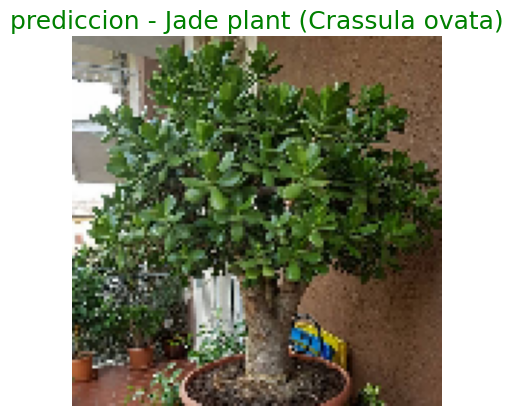

In [83]:
predict_img('/Users/jesusbarraza/Projects/clasificacion_plantas/split/prediction/9.jpeg', model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


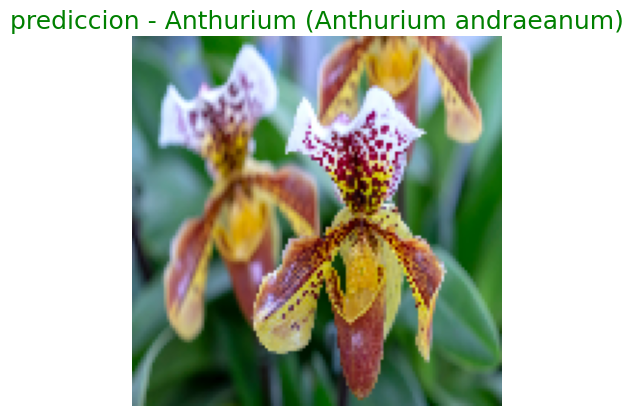

In [86]:
predict_img('/Users/jesusbarraza/Projects/clasificacion_plantas/split/prediction/17.jpeg', model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


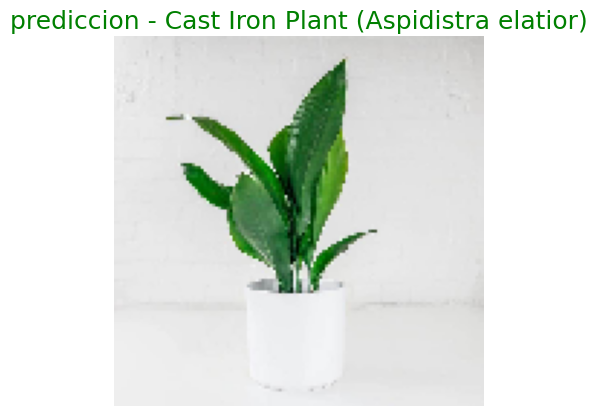

In [92]:
predict_img('/Users/jesusbarraza/Projects/clasificacion_plantas/split/prediction/23.jpeg', model)

### Realizar pruebas con 3 metricas distintas

**1 - Precision global**

In [94]:
model.evaluate(test_ds)

222/273 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.6761 - loss: 1.1631

2025-05-30 18:17:08.071286: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


240/273 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.6759 - loss: 1.1641

2025-05-30 18:17:09.097418: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


273/273 ━━━━━━━━━━━━━━━━━━━━ 17s 62ms/step - accuracy: 0.6758 - loss: 1.1651


[1.175206184387207, 0.6753662824630737]

Al evaluar el modelo con los datos de prueba, se obtuvo una **precisión de aproximadamente 67.5%**. Esto significa que el modelo acertó en casi 7 de cada 10 predicciones.

**2 - Precision, Recall y F1-Score**

In [95]:
from sklearn.metrics import classification_report
import numpy as np

y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred = model.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

print(classification_report(y_true, y_pred_classes, target_names=class_names))

2025-05-30 18:20:26.454781: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-05-30 18:20:27.631042: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-05-30 18:20:30.664936: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


197/273 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step

2025-05-30 18:20:42.454411: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


224/273 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step

2025-05-30 18:20:44.189594: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


273/273 ━━━━━━━━━━━━━━━━━━━━ 17s 57ms/step
                                            precision    recall  f1-score   support

     African Violet (Saintpaulia ionantha)       0.03      0.03      0.03        99
                                 Aloe Vera       0.03      0.03      0.03        73
          Anthurium (Anthurium andraeanum)       0.03      0.04      0.03       135
             Areca Palm (Dypsis lutescens)       0.01      0.02      0.01        57
       Asparagus Fern (Asparagus setaceus)       0.04      0.02      0.03        50
                    Begonia (Begonia spp.)       0.00      0.00      0.00        67
     Bird of Paradise (Strelitzia reginae)       0.00      0.00      0.00        50
         Birds Nest Fern (Asplenium nidus)       0.04      0.03      0.04        87
        Boston Fern (Nephrolepis exaltata)       0.01      0.01      0.01        88
                                  Calathea       0.00      0.00      0.00        99
      Cast Iron Plant (Aspidistr

**3 - Matriz de confusion**

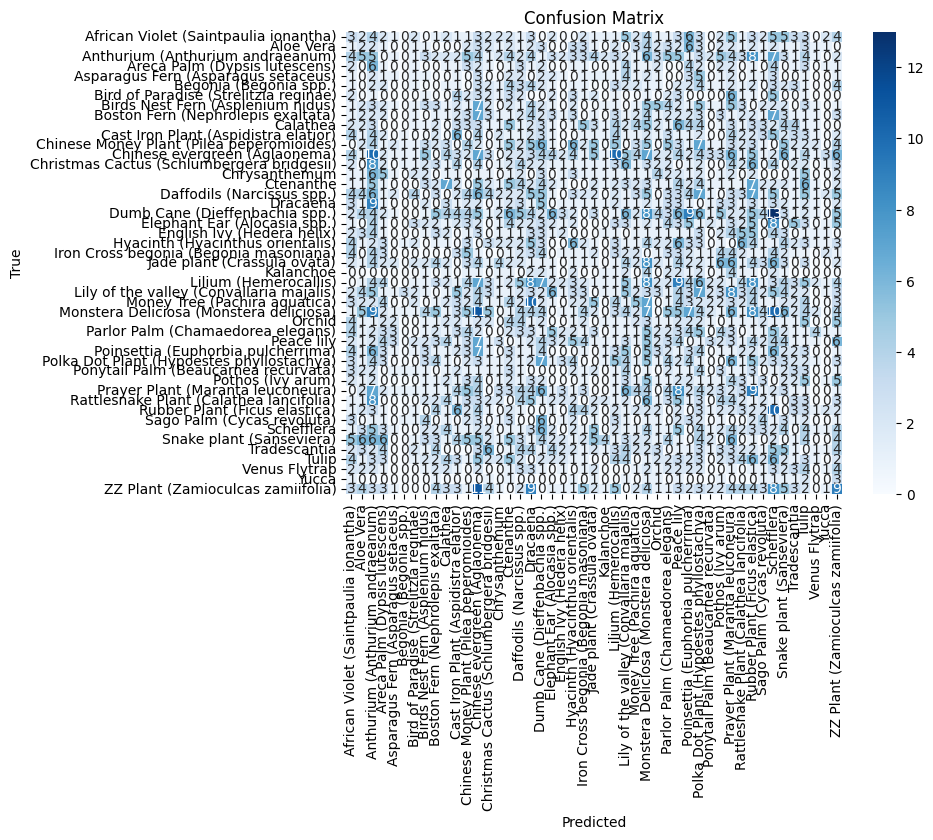

In [96]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()